In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
from matplotlib import rcParams
from latticeproteins.sequences import hamming_distance

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# Failed creations

In [2]:
import glob

In [3]:
dataset = "full-state-predictions"
path = "%s/results" % dataset
worked = glob.glob(path + "/networks-*")

In [4]:
indices = [int(s.split("-")[-1].split(".")[0]) for s in worked]
print(len(indices))

500


# Errant predictions

## Full space 

In [2]:
import pickle

In [115]:
dataset = "full-state-predictions"
filepath = "%s/results/statistics-output.pickle" % dataset

# Read file
with open(filepath, "rb") as f:
    dfluxes = pickle.load(f)
    dfluxes.pop(7)

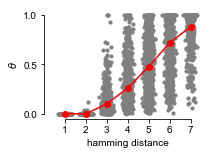

In [120]:
fig, ax = plt.subplots(figsize=(3,2))

means = []
for key, val in dfluxes.items():
    y = np.ma.masked_invalid(val)
    if 0 < key < 2:
        keep = np.where(val > 1e-2)[0]
    ymean = np.nanmean(y)
    x = np.ones(len(y)) * (key+1)
    xjitter = x + np.random.randn(len(x))* .1
    ax.scatter(xjitter,y, marker="o", color="gray", alpha=1, s=10)
    means.append(ymean)

x = range(1, 8)
y = means
ax.plot(x,y, "-or")
ax.set_xlabel("hamming distance")
ax.set_ylabel("$\\theta$")
ax.axis([0,8,-0.05,1.05])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_bounds(1, 7)
ax.spines["left"].set_bounds(0,1)
ax.set_yticks([0,.5,1])
l = ax.set_xticks(range(1,8))
#fig.savefig("figures/two-state-open-predictions.pdf", format="pdf")

In [5]:
with open(dataset + "/results/binary-input.pickle", "rb") as f:
    info = pickle.load(f)
    seqs = info["seq_pairs"]
    targets = info["targets"]
    dbs = info["dbs"]

In [121]:
keep


array([ 14,  41, 272, 290, 392, 446, 712, 749, 771, 807, 824, 912, 924])

In [126]:
import networkx as nx

def flux_out_of_node(G, node_i):
    """Determine """
    # Get flux coming from source
    total_flux_avail = G.node[node_i]["flux"]
    edges = {}
    # Normalize the transition probability from source
    norm = sum([G.edge[node_i][node_j]["weight"] for node_j in G.neighbors(node_i)])
    # Iterate over neighbors divvy up flux across neighbors
    for node_j in G.neighbors(node_i):
        if norm != 0:
            fixation = G.edge[node_i][node_j]["weight"]
            dflux = (fixation/norm) * total_flux_avail
            G.edge[node_i][node_j]["delta_flux"] = dflux
            G.node[node_j]["flux"] += dflux
        else:
            G.edge[node_i][node_j]["delta_flux"] = 0
    return edges

def flux_from_source(G, source):
    # Reset the flux of each node
    init_flux = dict([(node, 0) for node in G.nodes()])
    nx.set_node_attributes(G, "flux", init_flux)
    G.node[source]["flux"] = 1
    # Add flux to each node.
    levels = ring_levels(G, source)
    for l in levels:
        for node_i in levels[l]:
            edges = flux_out_of_node(G, node_i)
            for key, flux_to_add in edges.items():
                node_i, node_j = key
                G.node[node_j]["flux"] += flux_to_add
    return G

def ring_levels(G, root):
    levels = dict([(i,[]) for i in range(20)])
    levels[0].append(root)
    for node in G.nodes():
        neighbors = G.neighbors(node)
        for neigh in neighbors:
            key = hamming_distance(root, neigh)
            levels[key].append(neigh)
    for key, val in levels.items():
        z = sorted(list(set(val)))
        levels[key] = z
    return levels

def build_graphs(edges1, edges2, source):
    """Construct two different networks from a set of edges.
    """
    # -----------------------------------------------
    # build initial graphs
    # -----------------------------------------------
    edges0 = edges1
    # Build Graph
    G0 = nx.DiGraph()
    for key, weight in edges0:
        i,j = key[0], key[1]
        G0.add_edge(i,j, weight=weight["weight"])

    # Build Graph
    G2 = nx.DiGraph()
    for key, weight in edges2:
        i,j = key[0], key[1]
        G2.add_edge(i,j, weight=weight["weight"])

    seq = source
    # -----------------------------------------------
    # Calculate the flux at each node and edge
    # -----------------------------------------------
    G0 = flux_from_source(G0, seq)
    G2 = flux_from_source(G2, seq)

    # Get a dictionary of change in fluxes along each edge.
    edges_0 = dict([((i, j), G0.edge[i][j]["delta_flux"]) for i,j in G0.edges()])
    edges_2 = dict([((i, j), G2.edge[i][j]["delta_flux"]) for i,j in G2.edges()])

    # -----------------------------------------------
    # Calculate the change in delta_flux on each edge
    # -----------------------------------------------
    edges_diff = {}
    # See what edges we lost
    for key, val in edges_0.items():
        if key in edges_2:
            weight = edges_2[key] - edges_0[key]
            if weight < 0:
                # This edge gained flux
                color = "r"
            else:
                # This edge lost flux
                color = "b"
            edges_diff[key] = dict(color=color, weight=abs(weight))
        else:
            # This edge was lost in our predictions
            edges_diff[key] = dict(weight=val, color="r")

    # See what edges we gained.
    for key, val in edges_2.items():
        if key in edges_0:
            pass
        else:
            # This edge was gained in our predictions
            edges_diff[key] = dict(weight=val, color="b")

    # -----------------------------------------------
    # Calculate the change in flux at each node
    # -----------------------------------------------
    nodes_0 = dict([(i, G0.node[i]["flux"]) for i in G0.nodes()])
    nodes_2 = dict([(i, G2.node[i]["flux"]) for i in G2.nodes()])

    node_diff = {}
    for key, val in nodes_0.items():
        if key in nodes_2:
            diff = nodes_2[key] - val
            if diff > 0:
                color = "b"
            else:
                color = "r"
            node_diff[key] = dict(color=color, outer=nodes_2[key], inner=val)
        else:
            node_diff[key] = dict(color="r", outer=nodes_0[key], inner=0)

    for key, val in nodes_2.items():
        if key in nodes_0:
            pass
        else:
            node_diff[key] = dict(color="b", outer=val, inner=0)

    # -----------------------------------------------
    # Construct a network of differences
    # -----------------------------------------------
    Gdiff = nx.DiGraph()
    for key, val in edges_diff.items():
        Gdiff.add_edge(key[0],key[1],**val)

    for key, val in node_diff.items():
        Gdiff.node[key].update(**val)

    return G0, G2, Gdiff


In [127]:
d = 41

# Read in actual dataset
with open(dataset+"/results/walks-actual-"+str(d)+".pickle", "rb") as f:
    data = pickle.load(f)
    edges0 = data["edges"]
    seq = data["seq"]
    target = data["target"]
    temp = data["temp"]
    db = data["db"]

# Read in predicted dataset
with open(dataset+"/results/walks-predicted2-"+str(d)+".pickle", "rb") as f:
    data = pickle.load(f)
    edges2 = data["edges"]

    
# Quality control. Prevents numerical errors
#edges0 = [e for e in edges0 if e[1]["weight"] > 1e-9]
#edges2 = [e for e in edges2 if e[1]["weight"] > 1e-9]


G0, G2, Gdiff = build_graphs(edges0, edges2, seq)

junk = """
with open(dataset+"/results/networks-"+str(d)+".pickle", "rb") as f:
    data = pickle.load(f)
    G0 = data["Gactual"]
    G2 = data["Gpredict"]
    Gdiff = data["Gdiff"]
"""



def output(G0, G2, Gdiff, seq):
    rings = ring_levels(Gdiff, seq)

    # Add to summary statistic
    for ring, sequences in rings.items():

        if  ring < 8:

            diff, denom1, denom2 = 0, 0, 0
            for i in sequences:

                # Add up total flux exchange, and the difference between two networks
                for j in Gdiff.neighbors(i):

                    diff += Gdiff.edge[i][j]["weight"]

                    try: 
                        denom1 += G0.edge[i][j]["delta_flux"]
                        #print(denom1)
                    except: pass

                    try: 
                        denom2 += G2.edge[i][j]["delta_flux"]
                        #print(denom2)
                    except: pass

                    #if 0< ring < 2:
                     #   print(diff, denom1, denom2)

            denom = denom1 + denom2

            # Normalize the flux exchange at this hamming distance
            if denom != 0:
                print( diff/denom , denom)
            #else:
        #    print( 0 )
output(G0, G2, Gdiff, seq)

0.0 2.0
0.0 2.52837083058
0.0282196361156 1.98783371233
0.291718167111 1.99657571604
0.857972308667 2.38806656654
0.904529349766 1.4551513557
0.984373833006 0.775109673953


In [39]:

0.0 2.0
0.0304691779739 2.25318802575
0.176094273388 1.70330535142
0.509636845369 1.26200845788
0.909322295776 0.557422363517
0.983244018676 0.414529119486
0.99960136676 0.142300721369

SyntaxError: invalid syntax (<ipython-input-39-eabdab7d8cfa>, line 2)

In [90]:
import numpy as np
import networkx as nx
import pickle

from gpmap.utils import binary_mutations_map, find_differences
from latticegpm import LatticeGenotypePhenotypeMap
from latticeproteins.conformations import Conformations, ConformationList
from epistasis.models import EpistasisLinearRegression
from epistasis.simulate import NonlinearSimulation, LinearSimulation
from gpmap.evolve.models import fixation
from gpmap.graph.draw import network
from gpmap.graph.paths import paths_and_probabilities

dataset = "full-state-predictions"


with open(dataset + "/results/binary-input.pickle", "rb") as f:
    info = pickle.load(f)
    seqs = info["seq_pairs"]
    targets = info["targets"]
    dbs = info["dbs"]

j = 9
pair = seqs[j]
target = targets[j]
db = None #dbs[j][0:2]


# Prepare for GenotypePhenotypeMap
wildtype = pair[0]
length = len(wildtype)
mutations = binary_mutations_map(*pair)

# Determine the order of epistasis
changes = find_differences(*pair)
order = len(changes)

if db is None:
    c = Conformations(length)
else:
    c = ConformationList(length, db)

# Construct a genotype-phenotype map
gpm = LatticeGenotypePhenotypeMap(wildtype, mutations=mutations, target_conf=target)
gpm.fold(Conformations=c)

# Fit a high-order epistasis model
model = EpistasisLinearRegression.from_gpm(gpm, order=order, model_type="local")
model.fit()

# Calculate the average magnitude of epistasis
epistasis = []
for i in range(1,order+1):
    z = model.epistasis.get_orders(i)
    coefs_ = np.abs(z.values)
    # Protect numerical errors
    coefs_[coefs_ < 1e-9] = 0
    # Calculate mean
    mcoefs_ = np.mean(coefs_)
    epistasis.append(mcoefs_)


# Build a predicted genotype-phenotype map from epistasis
overlaps = {}
i = 2

# Get subset of epistasis
em = model.epistasis.get_orders(*range(i+1))

# Build map from epistatic coefs
sim2 = LinearSimulation.from_coefs(
    wildtype, mutations, em.labels, em.values,
    #function=lambda x: 1 / (1 + np.exp(x)),
    model_type="local")

# Build a network
#Gsim = sim.add_networkx()

# Model evolution in simulation
#Gsim.add_evolutionary_model(fixation)
#paths2 = enumerate_all_subpaths(Gsim)

#overlaps[i] = overlap_for_subpaths(paths1, paths2)



/home/zsailer/virtual/py3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


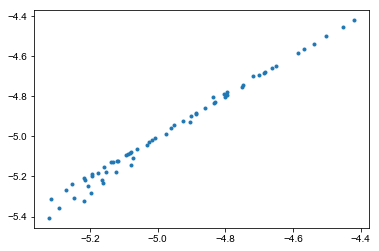

In [87]:
plt.plot(sim.phenotypes, gpm.phenotypes,'.')

In [92]:
n_muts = []
for i in range(gpm.n):
    n_muts.append(hamming_distance(gpm.wildtype, gpm.genotypes[i]))

In [94]:
with open("additive-predictions.csv", "w") as f:
    f.write("genotypes,n_muts,actuals,first-order,second-order\n")
    for i in range(sim.n):
        f.write("{:},{:},{:},{:},{:}\n".format(gpm.genotypes[i], n_muts[i], gpm.phenotypes[i], sim1.phenotypes[i], sim2.phenotypes[i]))

In [131]:
list(set(["test"]))


['test']